### Домашняя работа №4.

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей.

In [1]:
import numpy as np
import pandas as pd

- Загрузим датасет:

In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


- Переименуем поля (conversion -> target, offer -> treatment) и приведем поле treatment к бинарному виду:

In [3]:
df.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [4]:
df['treatment'] = np.where(df['treatment'] == 'No Offer', 0, 1).astype('i1')

- Разобьем датасет на тренировочную и тестовую выборки:

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=23)

X_train = df_train.drop(['treatment', 'target'], axis=1)
y_train = df_train['target']
treat_train = df_train['treatment']

X_test = df_test.drop(['treatment', 'target'], axis=1)
y_test = df_test['target']
treat_test = df_test['treatment']

cat_features = ['zip_code', 'channel']
models_results = {'model': [], 'uplift@10%': [], 'uplift@20%': []}

- Проведем uplift-моделирование 3мя способами:

In [7]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_curve
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

__Одня модель с признаком коммуникации__

In [8]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['model'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

In [9]:
sm_score_10, sm_score_20

(0.050903029096921765, 0.05372383894237706)

__Модель с трансформацией таргета__

In [10]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['model'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [11]:
ct_score_10, ct_score_20

(0.08754873851097858, 0.07091260624212184)

__Две независимые модели__

In [12]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features),
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['model'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

In [13]:
tm_score_10, tm_score_20

(0.09729766915058019, 0.09280448502464222)

- Выведем результаты метрик uplift@10% и uplift@20%, а также построим uplift-кривые для каждого метода:

In [14]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,model,uplift@10%,uplift@20%
2,TwoModels,0.097298,0.092804
1,ClassTransformation,0.087549,0.070913
0,SoloModel,0.050903,0.053724


Solo Model


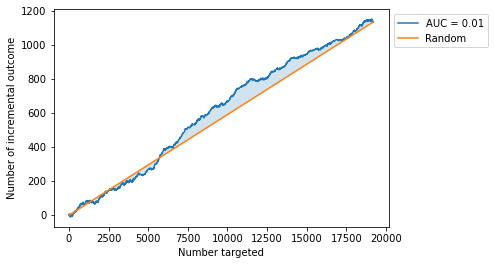

ClassTransform Model


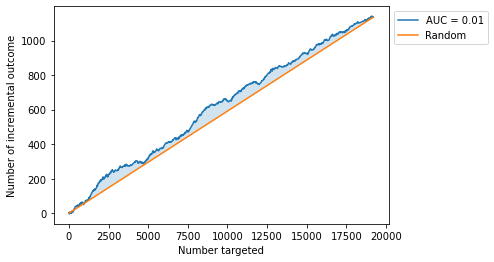

Two Model


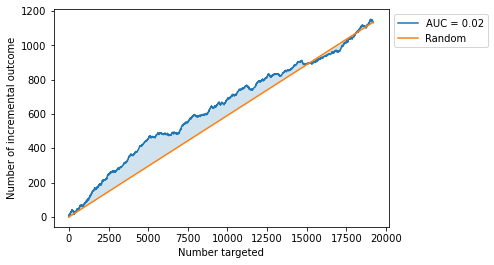

In [15]:
print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()

Как видим лучше всего с этой задачей справился метод с двумя независимыми моделями.